# Unsupervised Learning
This notebook demonstrates unsupervised learning techniques. 

If you are interested in identifying hidden patterns in data, specifically unlabelled (or unstructured) data, then this notebook will help guide you through unsupervised learning from data with Python. We'll use some key Python statistics and machine learning libaries:

* `sci-kit learn`
* `statsmodels`

For data, we've already collected over 200 speeches from the U.S. Secretary of Defense from the last 4 years. If you're curious to learn about webscraping or how this data was acquired, check out the notebook `data_collection.ipynb`. This is _text_, so it is inherently unstructured data. We'll use some basic natural language processing (NLP) techniques to convert this text into structured data.

Let's get started by importing some packages we'll need:

In [4]:
import numpy as np
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import feature_extraction
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Dealing with stopwords

Now, let's make sure that we have loaded NLTK's (a key Python NLP library) stopwords:

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Stopwords are words that are common to language and are important in context, but don't carry significant semantic meaning with respect to an overall text. For example, if you were looking at a news article about nuclear weapons in North Korea you could determine what the article was about based on the frequency of words like "nuclear", "weapons", and "North Korea". You wouldn't be able to learn much from words like "who", "when", "our", "me", etc.

Let's load nltk's English stopwords as variable called `stopwords`:

In [7]:
stopwords = stopwords.words('english')
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


### Tokenization and stemming

Next, we are going to define some functions to help us resolve words like "ran", "running", "runs" into a canonical (or _stemmed_) form (e.g. "run"). We'll use the NLTK [Snowball Stemmer](https://www.nltk.org/_modules/nltk/stem/snowball.html).

In [8]:
stemmer = SnowballStemmer("english")

In [9]:
stemmer.stem('runs')

'run'

In [10]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token) >= 4:
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token) >= 4:
                filtered_tokens.append(token)
    return filtered_tokens

Note that we'll also need to **_tokenize_** the speeches. This is the process of converting text into words.

For example, we would take 
```
"The quick brown fox jumped over the lazy dog."
```

and tokenize it into:
```
["The", "quick", "brown", "fox", "jumped", "over", "the", "lazy", "dog", "."]
```

This lets us generate frequency counts of words within speeches.

### Parsing our data
Let's read in the speeches as a dataframe and take a look at what we're dealing with!

In [14]:
df = pd.read_csv('datasets/SecState_Speeches.csv')
df.head()

,date,speech,title,url
0,"December 25, 2018","\nOn behalf of the Department of State, I woul...",On the Occasion of Christmas,http://www.state.gov/secretary/remarks/2018/12...
1,"December 21, 2018",\nQUESTION: Thanks very much for taking the ti...,Interview With Steve Inskeep of NPR,http://www.state.gov/secretary/remarks/2018/12...
2,"December 20, 2018","\nQUESTION: Good morning, Secretary. How are y...",Interview With Brian Grimmett of KMUW Wichita ...,http://www.state.gov/secretary/remarks/2018/12...
3,"December 20, 2018",\nQUESTION: (Inaudible.)\n\n\nSECRETARY POMPEO...,Interview With Bryce Dolan of 550 KFRM-AM,http://www.state.gov/secretary/remarks/2018/12...
4,"December 20, 2018",\nQUESTION: Pompeo is with us now. I don’t kno...,Interview With Laura Ingraham of The Laura Ing...,http://www.state.gov/secretary/remarks/2018/12...


Now we can tokenize and stem the speeches:

In [15]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in df.speech:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

We need to generate a vocabulary: this will be a mapping from stemmed version of words back to their original form. That way we can lookup a stemmed word and back into what it actually was (in human readable form).

In [16]:
vocab = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('There are ' + str(vocab.shape[0]) + ' items in our vocabulary.')

There are 186901 items in our vocabulary.


### tf-idf and calculating document similarity
To get a ff-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document. 

We will use this tf-idf matrix as a structured representation of the relationship between documents. We can use this to perform unsupervised learning: 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.speech) #fit the vectorizer to speeches

print(tfidf_matrix.shape)

/Users/brandon/anaconda/envs/p3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 8.77 s, sys: 66.4 ms, total: 8.83 s
Wall time: 8.85 s
(384, 575)


Note that the tf-idf matrix has 204 rows (one for each speech) and 1,593 columns (one for each word which met the thresholds we specified for our `TfidfVectorizer`.

We can get all the terms from our tf-idf matrix:

In [18]:
terms = tfidf_vectorizer.get_feature_names()

### K-means clustering
Now we're ready to perform clustering on our speeches. We'll pick an arbitrary, but human understandable, number of clusters. Let's try for 12 clusters.

In [19]:
from sklearn.cluster import KMeans

num_clusters = 6

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 2.75 s, sys: 8.26 ms, total: 2.75 s
Wall time: 2.76 s


We need to add the cluster labels to our dataset. This let's us see how many speeches ended up in each cluster:

In [20]:
df['cluster'] = clusters
df.groupby('cluster')['cluster'].count()

cluster
0     37
1     44
2     72
3     74
4     19
5    138
Name: cluster, dtype: int64

Now we can inspect the top terms in each of these clusters and compare them with the speech titles. This should give us a good sense of whether or not our clustering was successful.

In [22]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print("{0}Top terms per cluster:{1}".format(color.BOLD,color.END))
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("{0}Cluster {1} Words:{2}".format(color.BLUE + color.BOLD, i, color.END))
    
    for ind in order_centroids[i, :10]:
        word = str(vocab.loc[terms[ind].split(' ')].values.tolist()[0][0])
        print('\t-{0}'.format(word))
    print('')
    
    print("{0}Cluster {1} Speech Titles:\n{2}".format(color.GREEN + color.BOLD, i, color.END))
    titles = df[df['cluster'] == i].title
    for title in titles[:10]:
        print('\t- {0}'.format(title[:100]))
    print('\n\n')
    
print('\n')

Top terms per cluster:

Cluster 0 Words:
	-secretary
	-north
	-korea
	-north
	-president
	-thanks
	-question
	-china
	-pompeo
	-secretary

Cluster 0 Speech Titles:

	- Press Availability at the U.S. - Canada 2+2 Ministerial
	- Press Availability With Secretary of Defense James Mattis, Chinese Politburo Member Yang Jiechi, and
	- Remarks to Traveling Press
	- Remarks at the Conference on Prosperity and Security in Central America
	- Remarks With Chinese Director of the Central Foreign Affairs Commission Office Yang Jiechi Before Th
	- Remarks With Chinese Foreign Minister Wang Yi Before Their Meeting
	- Remarks With South Korean President Moon Jae-in
	- Remarks With Japanese Prime Minister Shinzo Abe
	- Remarks at a Meeting on the Democratic People's Republic of Korea
	- On the Outcome of Summit Meeting Between President Moon and Chairman Kim



Cluster 1 Words:
	-embedded_plugin_status
	-embedded_plugin_q
	-embedded_plugin_status
	-typeof
	-.push
	-embedded_plugin_q
	-undefined
	-else


### Visualizing our clusters

Let's use t-Distributed Stochastic Neighbor Embedding, or [t-SNE ](https://lvdmaaten.github.io/tsne/), for dimensionality reduction. This let's us project highly dimensional data, such as our tfidf matrix, into 2 dimensional space. This will let us visualize the clustering in 2-dimensions. Remember that much is lost projecting data with over 1500 features into 2d space!

In [23]:
data = tfidf_matrix.toarray()
projection = TSNE().fit_transform(data)

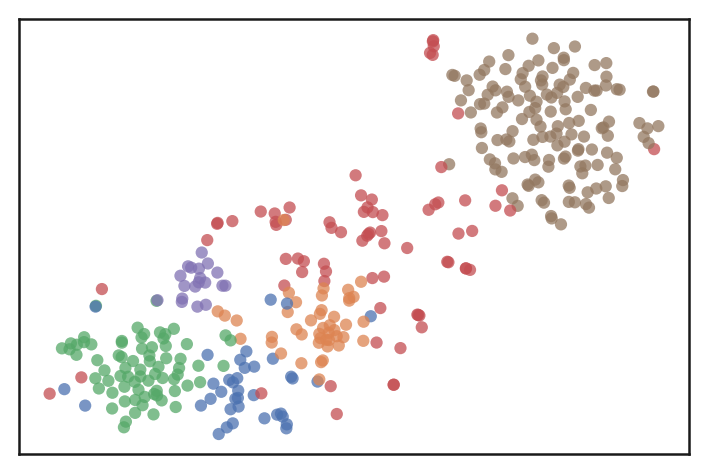

In [24]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'marker': 'o', 'alpha' : 0.75, 's' : 150, 'linewidths':0}

labels = clusters
palette = sns.color_palette(palette='deep', n_colors=np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.75, 0.75, 0.75) for x in labels]

fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.05)

plt.scatter(*projection.T, c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


plt.show()